In [6]:
# import libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import gc
import geopandas as gpd
import os
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.tree import export_graphviz
from IPython.display import Image
from sklearn import preprocessing
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
# import pymannkendall as mk
from collinearity import SelectNonCollinear
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import f_classif, mutual_info_classif
from scipy.stats import spearmanr
from scipy.cluster import hierarchy
from scipy.spatial.distance import squareform
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split
from scipy.stats import pearsonr
from statsmodels.graphics.tsaplots import plot_acf
from collections import defaultdict
import geopandas as gpd
import os
from sklearn import metrics
from sklearn.inspection import permutation_importance
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix



In [2]:
# EDA plots
# in functions (below), called for each step in the feature selection processs

# correlation coefficiant heatmap
def make_heatmap(df, response):
    if response in df.columns:
        df = df.drop(response, axis=1)
    else:
        df= df

    df_corr = df.corr().round(2)

    print("Columns at this stage:")
    print(df.columns)

    print("Pearson's correlation heatmap:", )
    plt.figure(figsize=(15, 15))
    sns.heatmap(
        df_corr,
        annot=True,
        square=True,
        cmap="coolwarm",
        mask=np.triu(np.ones_like(df_corr, dtype=bool)),
    )

# variance inflation factor table
def get_VIF_table(df, response):
    if response in df.columns:
        df = df.drop("Fire_Type", axis=1)
    else:
        df = df

    vif = pd.DataFrame()
    vif["variables"] = df.columns
    vif["VIF"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]

    print("VIF for this dataset:")
    print(vif)

# hierarchal clustering chart 
def get_dendrogram(df, response):
    if response in df.columns:
        df = df.drop("Fire_Type", axis=1)
    else:
        df = df

    print("Spearman's Correlation Hierarchy Chart")
    fig, ax = plt.subplots(figsize=(12, 8))
    corr = spearmanr(df).correlation
    corr = (corr + corr.T) / 2
    np.fill_diagonal(corr, 1)

    distance_matrix = 1 - np.abs(corr)
    dist_linkage = hierarchy.ward(squareform(distance_matrix))
    dendro = hierarchy.dendrogram(
        dist_linkage, labels=df.columns.tolist(), ax=ax, leaf_rotation=90
    )

##### -----------------------<i>This code is runnable-------------------------

In [3]:
# create the pipeline with selectnoncilliear, seaquentialfeatureselection, and RF
def get_pipeline(RF_n_estimators, correlation_treshold, SFS_n_features, cv):
    model = RandomForestClassifier(n_estimators=RF_n_estimators)
    SNC = SelectNonCollinear(correlation_threshold=correlation_treshold, scoring=f_classif)
    SFS = SequentialFeatureSelector(estimator=model,n_features_to_select=SFS_n_features,direction="forward", scoring="balanced_accuracy", cv=cv, n_jobs=-1)
    pipeline = make_pipeline(SNC, SFS, model)
    return pipeline

# preprocessing - includes: encoding, removing WF and BP poins that may be one and the same
# also includes stratified sampling and code to produce a "leftover" dataset
# that will be unused and unseen by the RF model
# but can be used to test further
def preprocess_data(original_data, year, response):
    d = defaultdict(preprocessing.LabelEncoder)
    df = original_data
    filtered_df = df[df["Year"] == year].copy()
    # filtered_df['Date']  = pd.to_datetime(filtered_df['Date'])
    print("Original data num rows for year", year, filtered_df.shape[0])

    spatial_overlap = filtered_df[filtered_df[response] == "Permit_Burn"].sjoin_nearest(filtered_df[filtered_df[response] == "Wildfire"], max_distance=30, lsuffix="class1_", rsuffix="class2_", how="left")
    if spatial_overlap.shape[0] > 0:
        date_overlap = spatial_overlap[spatial_overlap[response] == "Permit_Burn"].loc[:,'DOY'].eq(spatial_overlap[spatial_overlap[response] == "Wildfire"].loc[:,'DOY'])
        print("Num rows potentially overlapping: ", date_overlap.shape[0])
        filtered_df = filtered_df.drop(date_overlap.class1_index, axis=0).drop('geometry', axis=2)
    else:
        filtered_df = filtered_df.drop('geometry', axis=1)
        print("No overlapping data found.")


    response_value_count_min = np.sort(filtered_df[response].value_counts()).min()
    sample_num = int(response_value_count_min - (response_value_count_min * 0.15))
    sampled_df = filtered_df.groupby(f"{response}", group_keys=False).apply(lambda x: x.sample(sample_num) if len(x) >= sample_num else x.sample(len(x)))
    sampled_encoded_df = sampled_df.drop('Year', axis=1).apply(lambda x: d[x.name].fit_transform(x))
    print("Num rows in sampled df: ", sampled_encoded_df.shape[0])
        
        
    left_over = filtered_df.drop(sampled_encoded_df.index, axis=0)
    LO_value_count_min = np.sort(left_over[response].value_counts()).min()
    sampled_LO = left_over.groupby(f"{response}", group_keys=False).apply(lambda x: x.sample(LO_value_count_min) if len(x) >= LO_value_count_min else x.sample(len(x)))
    print("Num rows in sampled leftover df: ", sampled_LO.shape[0])

    return sampled_encoded_df, sampled_LO

# steps to start implementing pipeline
def feature_sel_pipeline(sampled_data, response):
    charts_functions = [make_heatmap, get_VIF_table, get_dendrogram]
    X_labeled, y_labeled = sampled_data.drop(f"{response}", axis=1), sampled_data[response]
    X, y = np.array(X_labeled), np.array(y_labeled)
    print("Initial everything:")
    for i in charts_functions:
        i(X_labeled, response)
 
    
    RF_n_estimators, correlation_threshold, SFS_n_features, cv = 100, 0.7, 8, 10
    stage_1, stage_2, stage_3 = get_pipeline(RF_n_estimators, correlation_threshold, SFS_n_features, cv).fit(X, y)

    print("Non-correlated feature selection results:")
    nc_idx = stage_1.get_support()
    SNC_res = X_labeled.iloc[:, nc_idx]
    print(SNC_res.columns)

    for i in charts_functions:
        i(SNC_res, response)

    print("Sequential Feature Selector results:")
    fs_idx = stage_2.get_support()
    SFS_sel = SNC_res.iloc[:, fs_idx]

    for i in charts_functions:
        i(SFS_sel, response)

    return y_labeled, SNC_res, SFS_sel, stage_3

# fit/run model
# calculate model metrics
# including feature importance and permutation importance
def model(df, response, mod):
    X_labeled, y_labeled = df, response
    X, y =  np.array(df), np.array(response)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
    mod.fit(X_train, y_train)
    y_pred = mod.predict(X_test)

    acc_score = metrics.accuracy_score(y_test, y_pred)
    avg_prec_score = metrics.average_precision_score(y_test, y_pred)
    recall_score = metrics.recall_score(y_test, y_pred)
    bal_acc_score = metrics.balanced_accuracy_score(y_test, y_pred)
    f1_score = metrics.f1_score(y_test, y_pred)
    roc_auc_score = metrics.roc_auc_score(y_test, y_pred)

    cv = StratifiedKFold(n_splits=10, shuffle=True)
    n_scores = cross_val_score(mod, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
    cv_score = n_scores.mean()

    feat_importance_idx = mod.feature_importances_.argsort()
    feat_importances = X_labeled.columns[feat_importance_idx]

    permutation_importance_ = permutation_importance(mod, X_test, y_test, random_state=42, n_jobs=-1)
    sorted_importance_idx = permutation_importance_.importances_mean.argsort()
    permutation_importances = X_labeled.columns[sorted_importance_idx]

    return bal_acc_score, acc_score, avg_prec_score, recall_score, f1_score, roc_auc_score, cv_score, feat_importances, permutation_importances

In [4]:
path = "F:/RMonaghan_Workspace/Projects_Main/GM/Exports/Full_DS_w_GEOM.parquet.gzip"
original_data = gpd.read_parquet(path)
original_data


Fire_Type                           US_L4NAME  \
0          Wildfire                   Okefenokee Plains   
1          Wildfire                   Okefenokee Plains   
2          Wildfire                   Okefenokee Plains   
3          Wildfire                   Okefenokee Plains   
4          Wildfire                   Okefenokee Plains   
...             ...                                 ...   
124602  Permit Burn                         Big Cypress   
124603  Permit Burn           Eastern Florida Flatwoods   
124604  Permit Burn  Central Florida Ridges and Uplands   
124605  Permit Burn                                None   
124606  Permit Burn              Big Bend Coastal Marsh   

                             US_L3NAME       LD  DOY  WOY  Year  MOY  QT  \
0               Southern Coastal Plain   Public    3    1  2010    1   1   
1               Southern Coastal Plain   Public    3    1  2010    1   1   
2               Southern Coastal Plain   Public    4    2  2010    1   1   
3               Southern Coastal Plain  Private    2   18  2010    5   2   
4               Southern Coastal Plain   Public    7   18  2010    5   2   
...                                ...      ...  ...  ...   ...  ...  ..   
124602  Southern Florida Coastal Plain   Public    4   26  2020    6   2   
124603          Southern Coastal Plain   Public    5   34  2020    8   3   
124604          Southern Coastal Plain   Public    3   47  2020   11   4   
124605                            None   Public    2   48  2020   11   4   
124606          Southern Coastal Plain   Public    3   50  2020   12   4   

           Area  ...  pr_mm_scaled  rmin_pct_scaled  rmax_pct_scaled  \
0       1818.00  ...           0.0             20.5             60.0   
1          4.00  ...           0.0             20.4             57.3   
2          5.00  ...           0.0             30.7            100.0   
3          3.27  ...          19.0             48.5             99.9   
4       3740.00  ...           0.0             31.1             92.4   
...         ...  ...           ...              ...              ...   
124602  5184.00  ...           0.0             50.7            100.0   
124603    25.00  ...           0.0             54.5            100.0   
124604  2741.00  ...           0.0             45.0             96.9   
124605     1.00  ...           1.7             57.1             95.1   
124606  3702.00  ...           0.0             40.0            100.0   

        sph_kg_per_kg  srad_W_per_m2  th_deg_clockwise_from_N  vs_m_per_s  \
0             0.00160          175.8                      290         4.0   
1             0.00159          175.3                      292         4.0   
2             0.00415          104.4                       14         1.7   
3             0.01462          229.1                      100         3.0   
4             0.00856          339.2                       83         3.8   
...               ...            ...                      ...         ...   
124602        0.02078          302.0                      123         2.0   
124603        0.01951          259.9                      151         3.3   
124604        0.00934          157.5                       39         6.4   
124605        0.01404          178.2                       52         5.2   
124606        0.00548          157.0                      283         3.0   

        vpd_kPA  erc_g_unitless                        geometry  
0           5.0              34  POINT (365732.260 3354987.532)  
1           5.1              35  POINT (350209.364 3358700.303)  
2           6.6              33  POINT (371310.297 3359107.609)  
3          10.3              17  POINT (377279.070 3355651.827)  
4          12.5              32  POINT (357250.371 3353925.292)  
...         ...             ...                             ...  
124602     10.0              21  POINT (461424.799 2894485.638)  
124603     10.2              15  POINT (545732.251 3098602.819)  
1246

In [5]:
# to call all functions yearly
def call_funcs(min_year, max_year,original_data):
    snc_cols = []
    sfs_cols = []
    accs = []
    bal_accs = []
    avg_precs = []
    recall_score = []
    f1_score = []
    roc_aucs = []
    fi_cols = []
    pi_cols = []
    cv_scores = []

    original_data=original_data
    years = np.arange(min_year, max_year+1, 1)
    df = original_data
    response = "Fire_Type"
    
    for year in years:
        print("Processing for year: ", year)

        sampled_encoded_ds, sampled_LO = preprocess_data(df, year, response)
        y, snc, final, rf = feature_sel_pipeline(sampled_encoded_ds, response)
        bal_acc, acc_score, avg_prec, recall, f1, roc_auc, cv_score, feat_importances, permutation_importances = model(final, y, rf)

        snc_cols.append(snc.columns.values.astype(str))
        sfs_cols.append(final.columns.values.astype(str))
        fi_cols.append(feat_importances.values.astype(str))
        pi_cols.append(permutation_importances.values.astype(str))
        accs.append(acc_score)
        cv_scores.append(cv_score)
        bal_accs.append(bal_acc)
        avg_precs.append(avg_prec)
        recall_score.append(recall)
        f1_score.append(f1)
        roc_aucs.append(roc_auc)

    res = pd.DataFrame()
    res['Year'] = years
    res['Uncorrelated Features'] = snc_cols
    res['Forward Selection'] = sfs_cols
    res['Feature Importance'] = fi_cols
    res['Permutation Importance'] = pi_cols
    res['Balanced Accuracy'] = bal_acc
    res['Accuracy Score'] = accs
    res['ROC AUC'] = roc_aucs
    res['f1'] = f1_score
    res['Average Precision'] = avg_precs
    res['Recall'] = recall_score
    res['CV Scores'] = cv_scores    
      
    return res
    

Processing for year:  2010
Original data num rows for year 2010 15652
No overlapping data found.
Num rows in sampled df:  3340
Num rows in sampled leftover df:  546
Initial everything:
Columns at this stage:
Index(['US_L4NAME', 'US_L3NAME', 'LD', 'DOY', 'WOY', 'MOY', 'QT', 'Area',
       'tmmn_F', 'tmmx_F', 'etr_mm_scaled', 'fm100_pct_scaled',
       'fm1000_pct_scaled', 'pet_mm_scaled', 'pr_mm_scaled', 'rmin_pct_scaled',
       'rmax_pct_scaled', 'sph_kg_per_kg', 'srad_W_per_m2',
       'th_deg_clockwise_from_N', 'vs_m_per_s', 'vpd_kPA', 'erc_g_unitless'],
      dtype='object')
Pearson's correlation heatmap:
VIF for this dataset:
                  variables          VIF
0                 US_L4NAME     3.832614
1                 US_L3NAME     5.160856
2                        LD     1.627448
3                       DOY     3.301238
4                       WOY   155.945023
5                       MOY   183.160160
6                        QT    40.960258
7                      Area     2

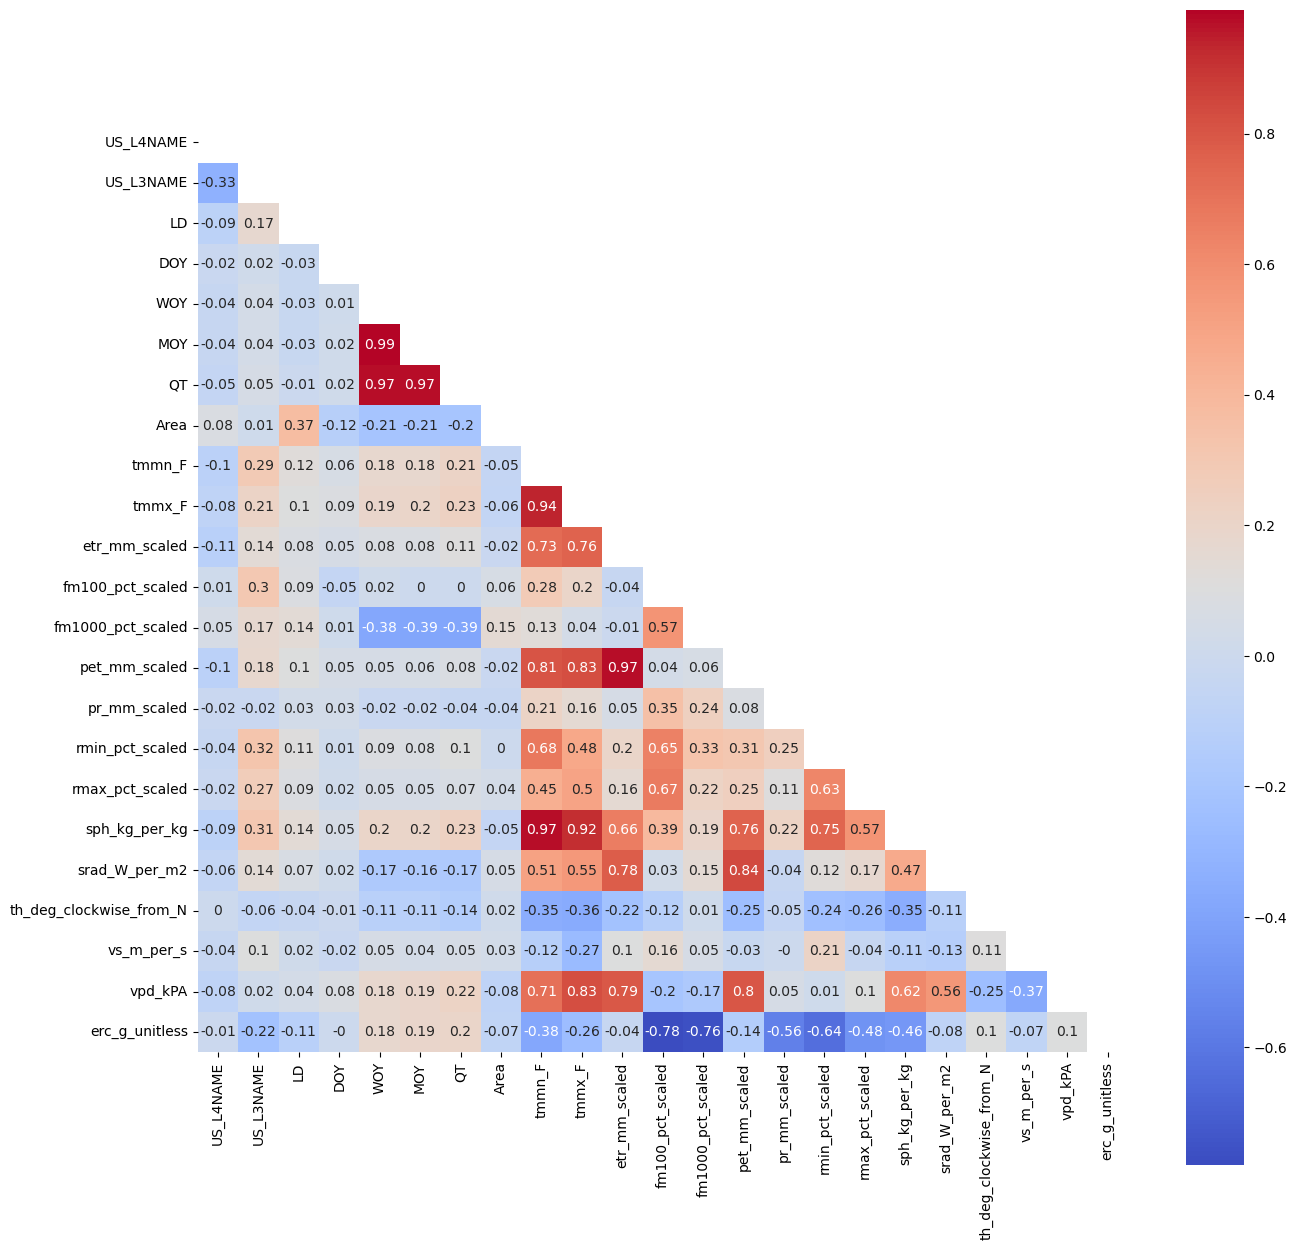

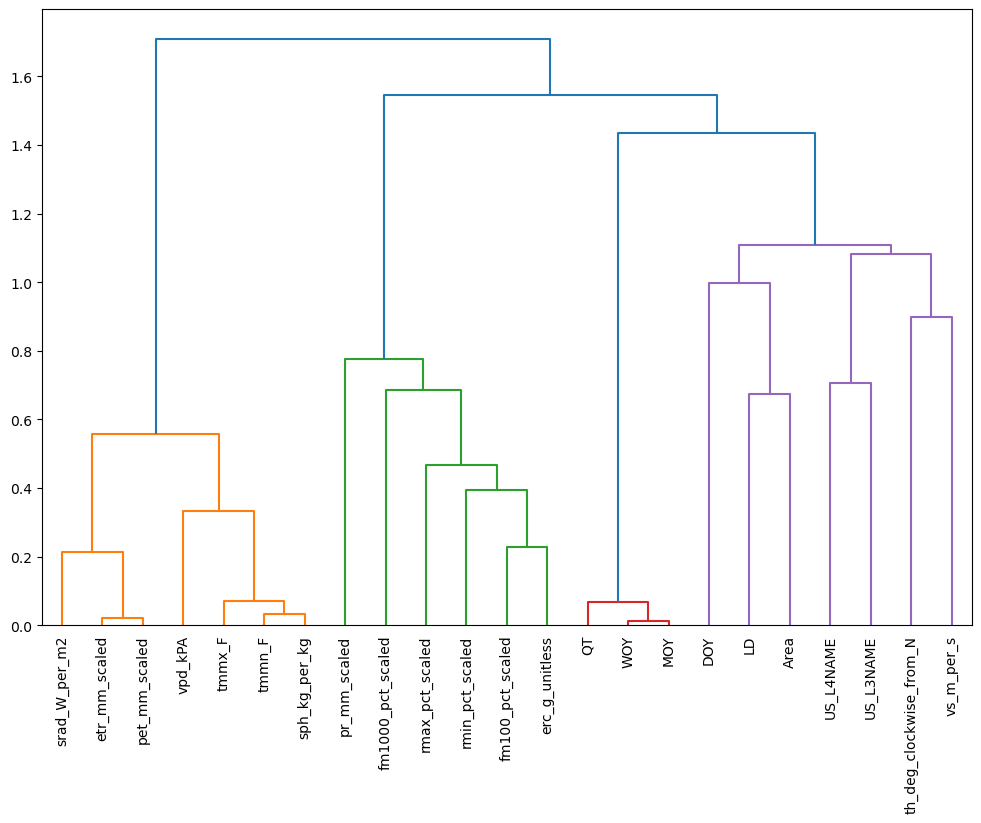

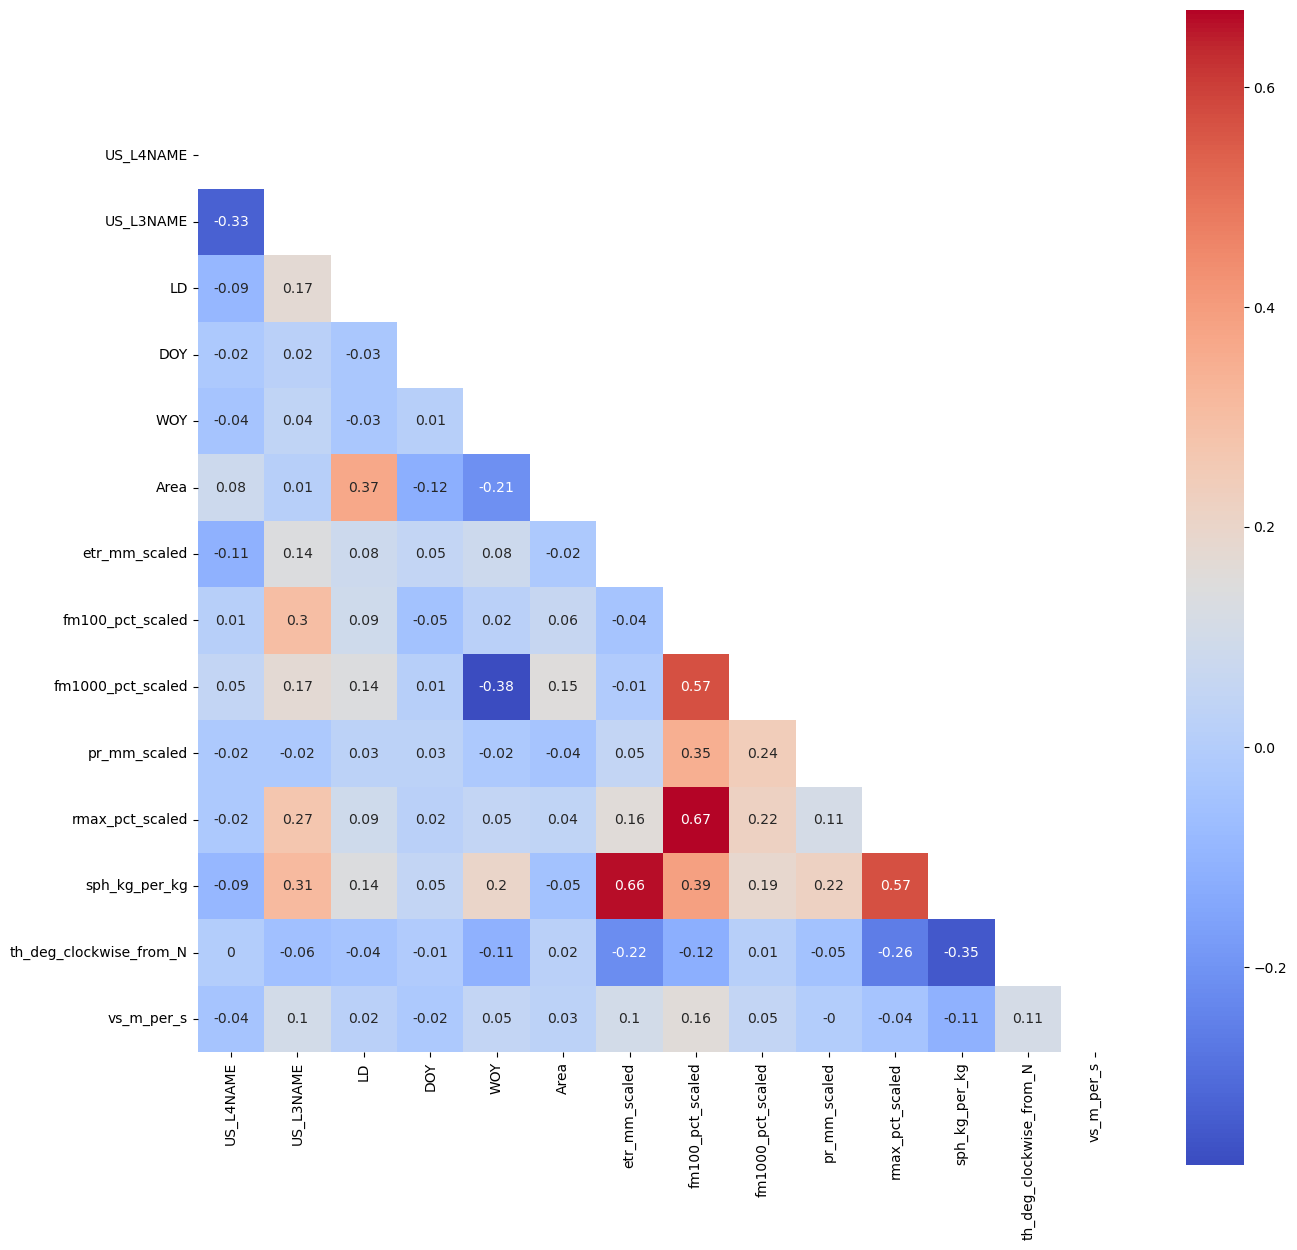

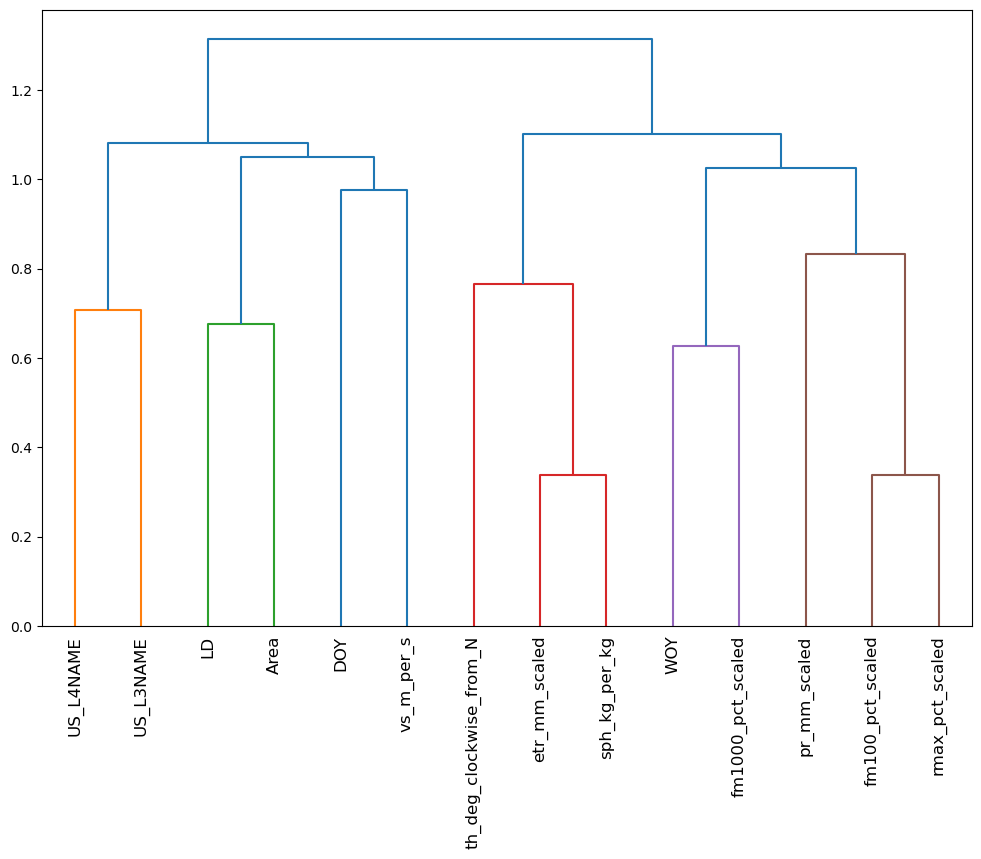

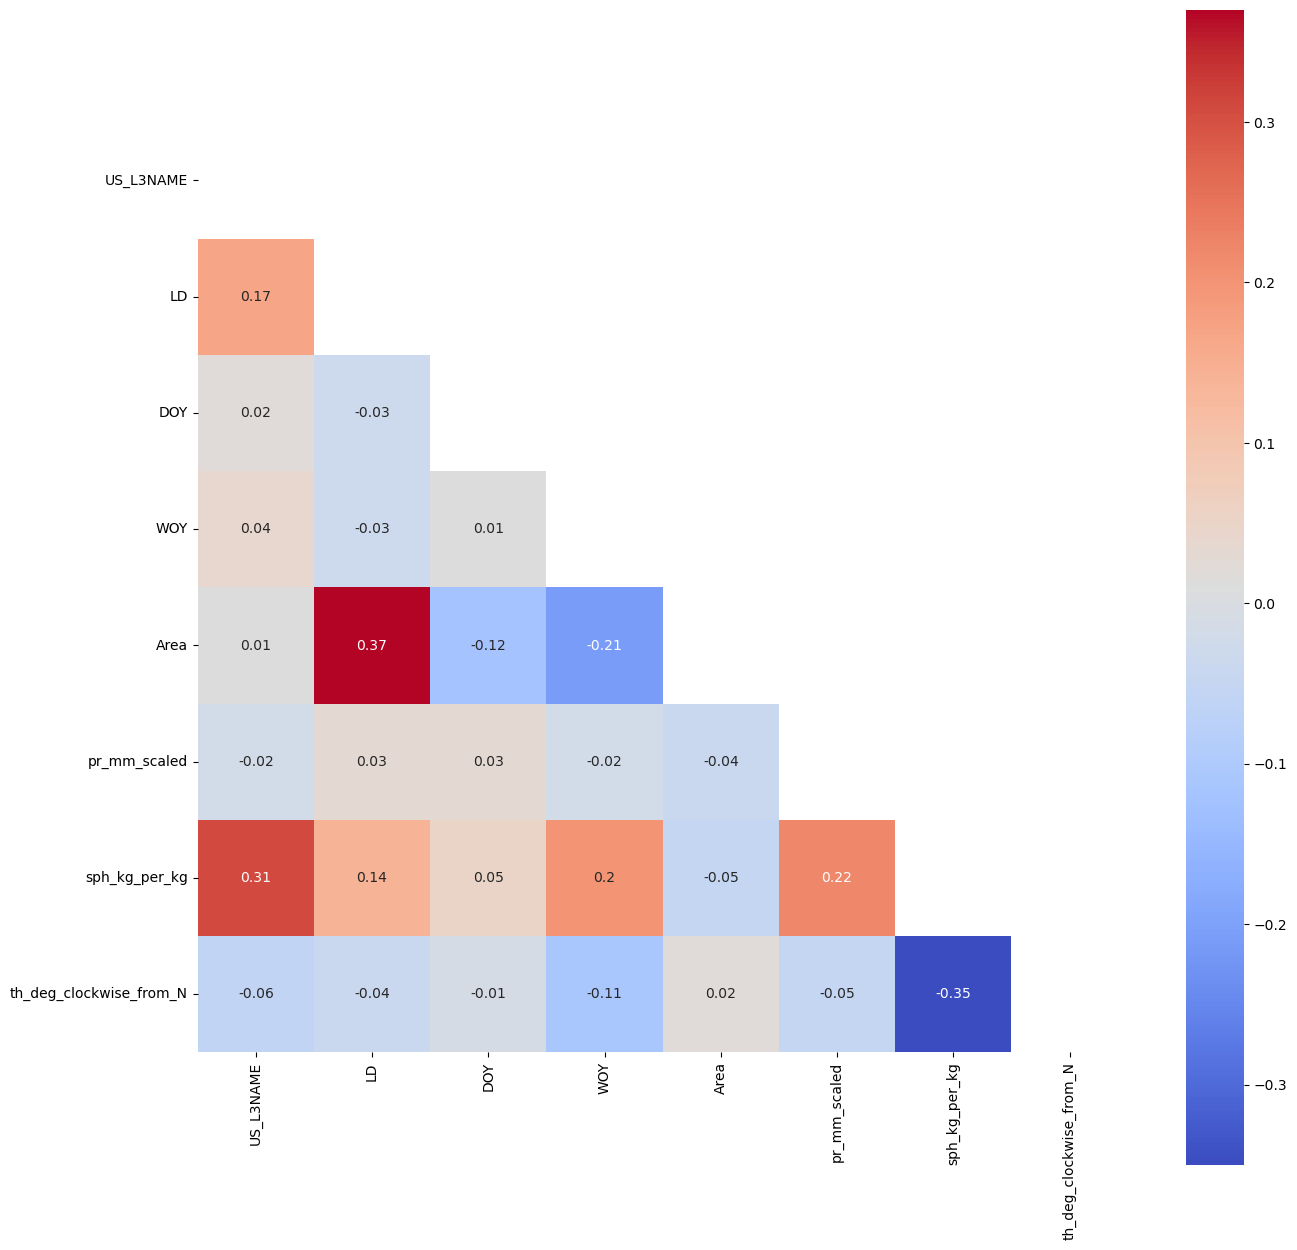

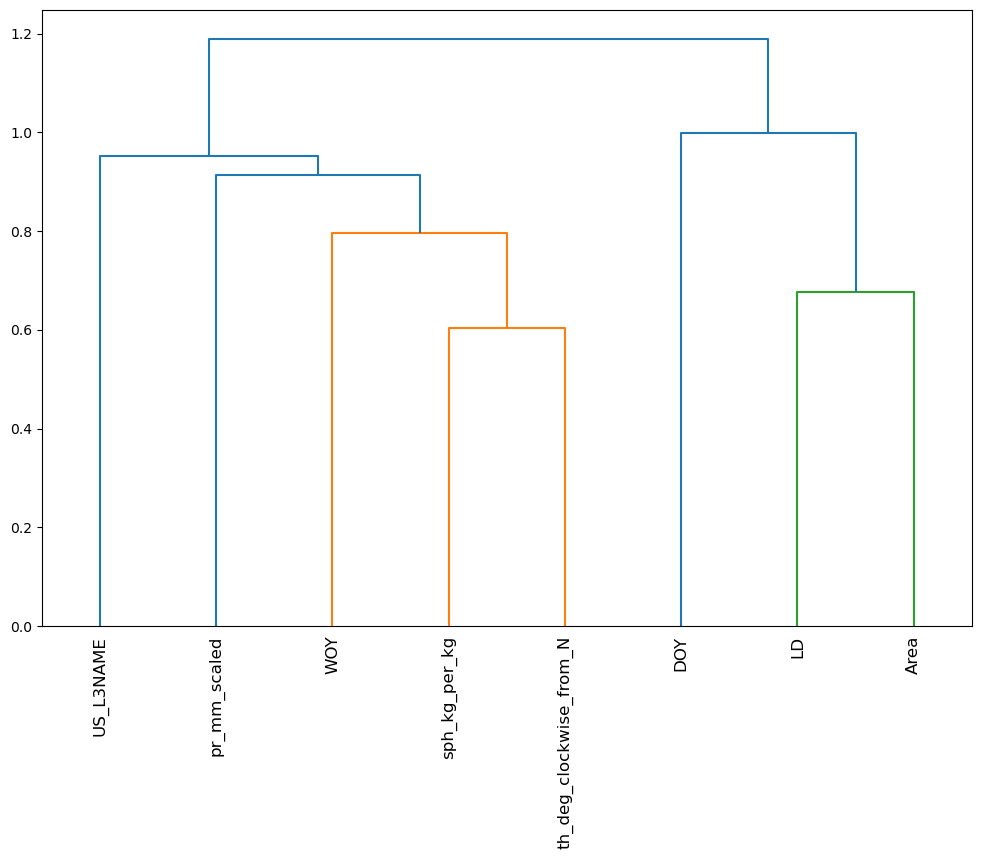

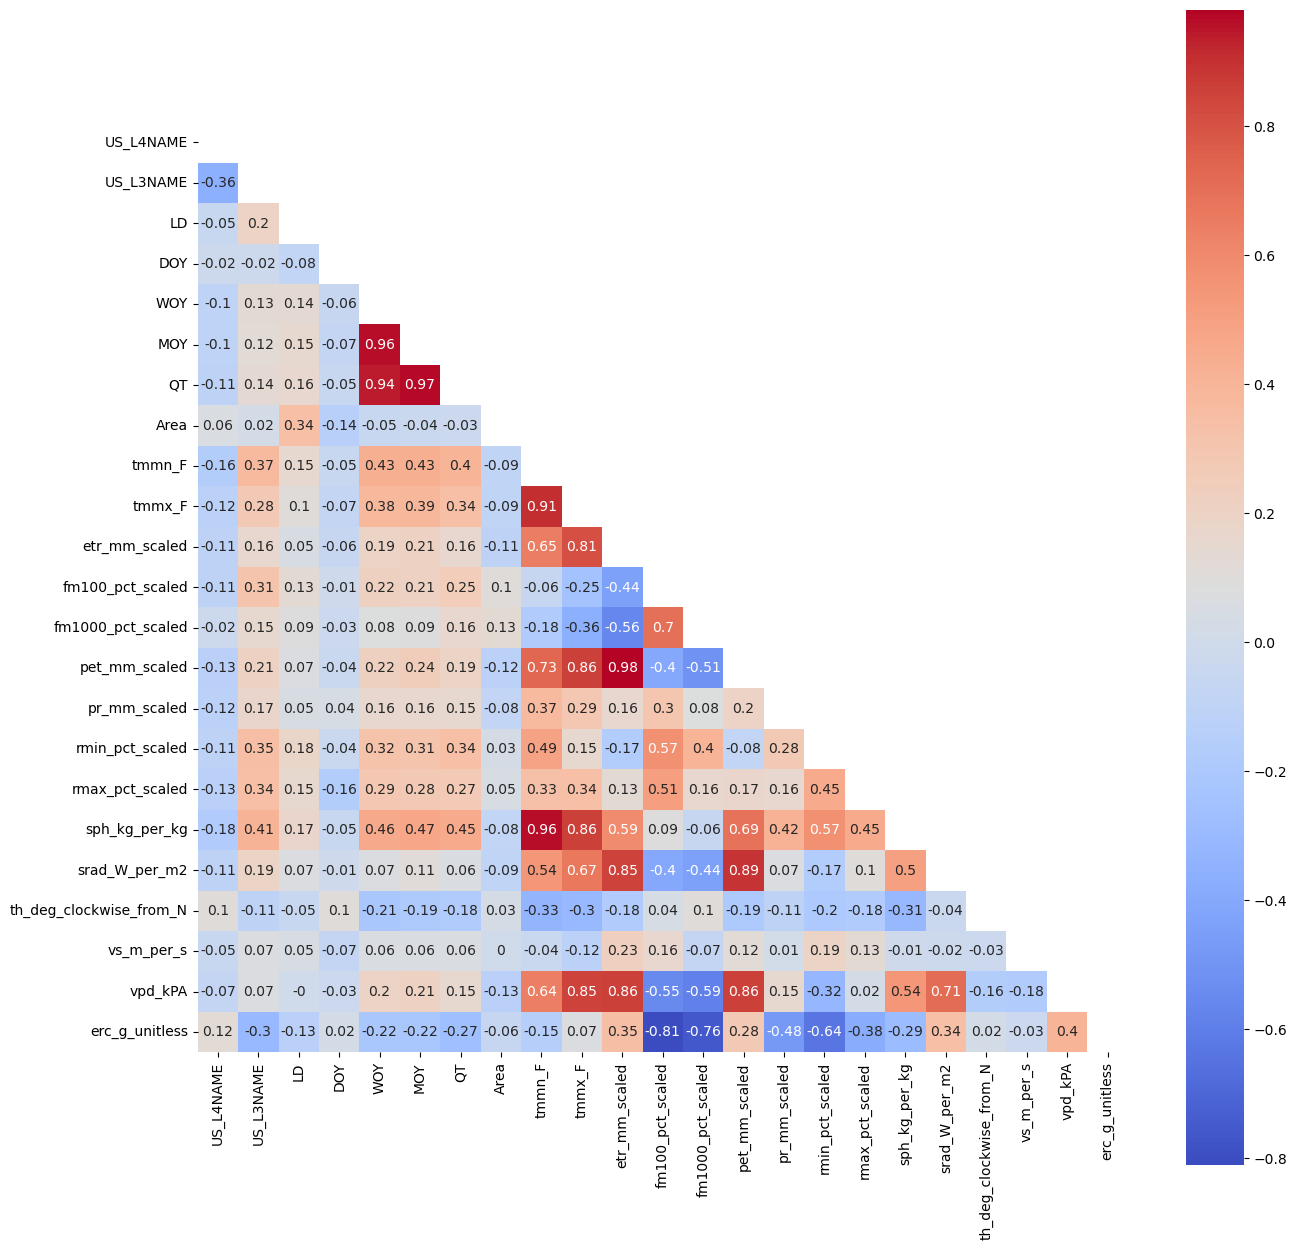

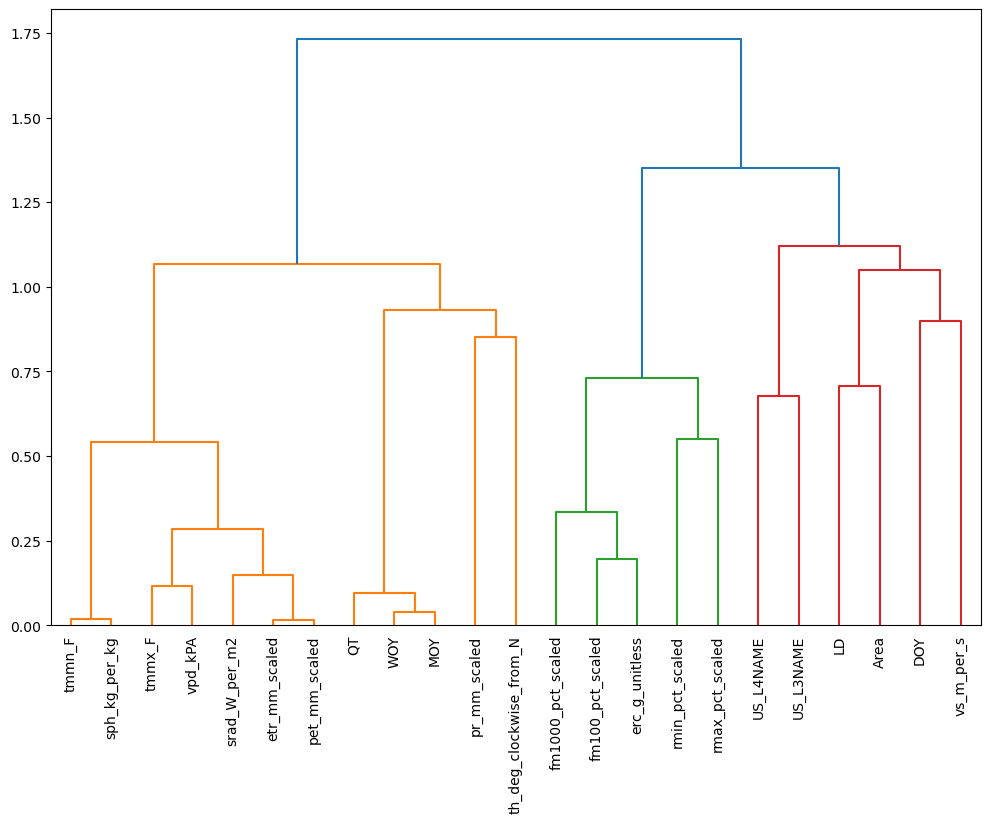

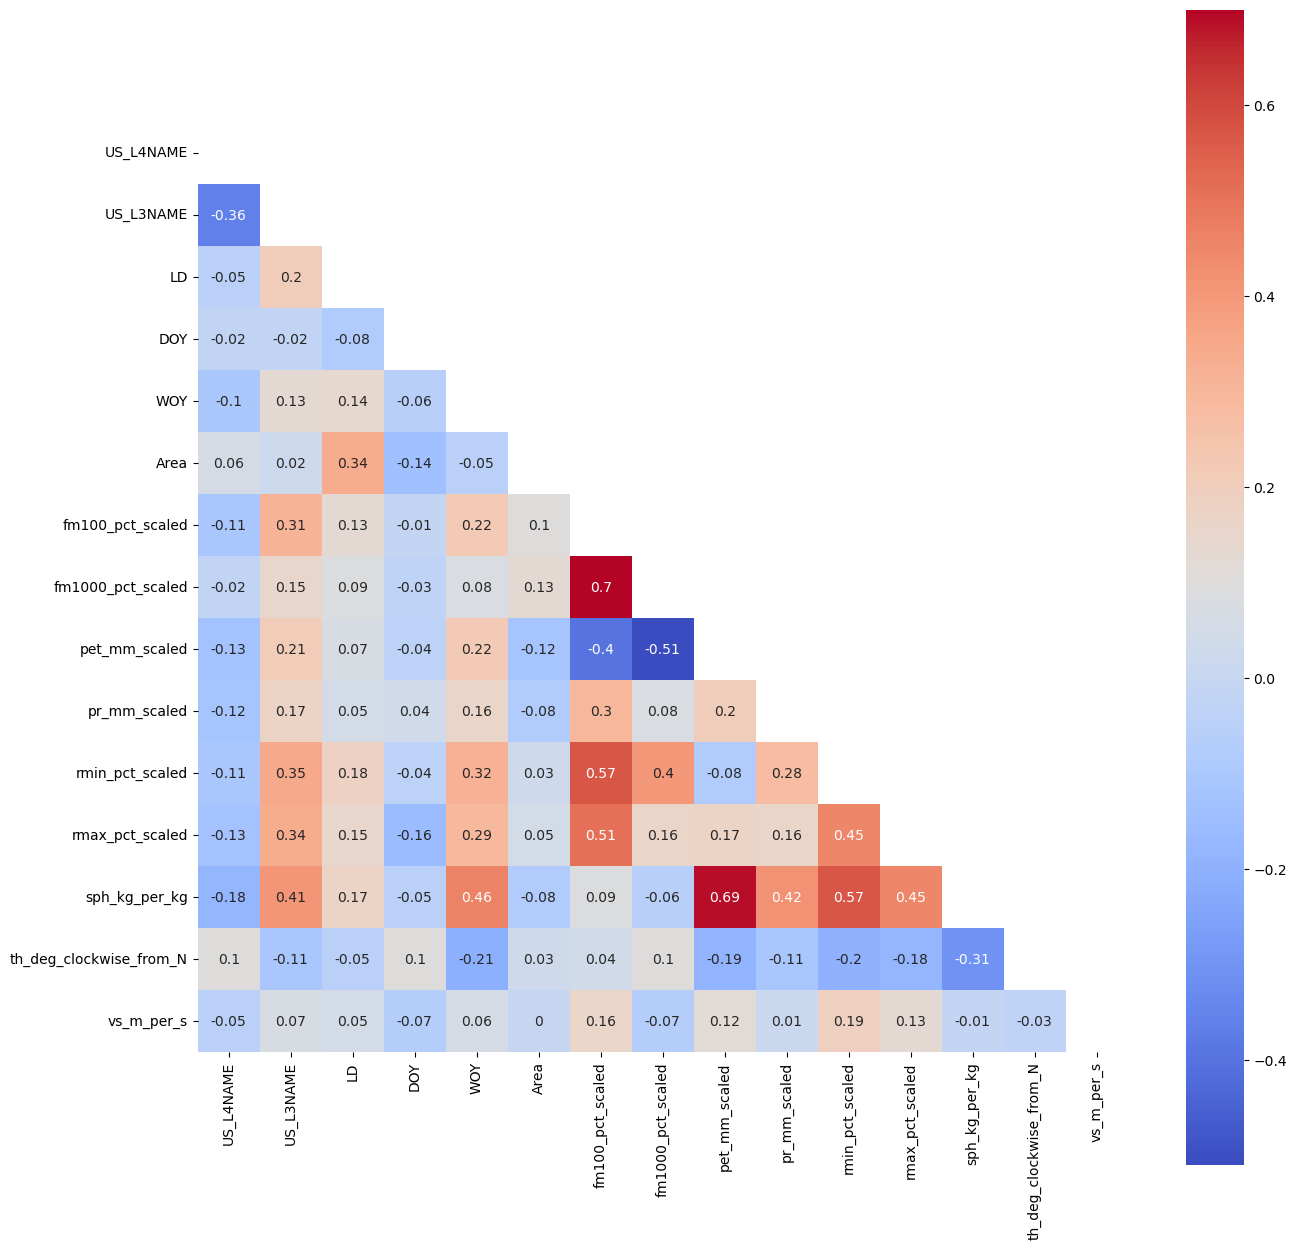

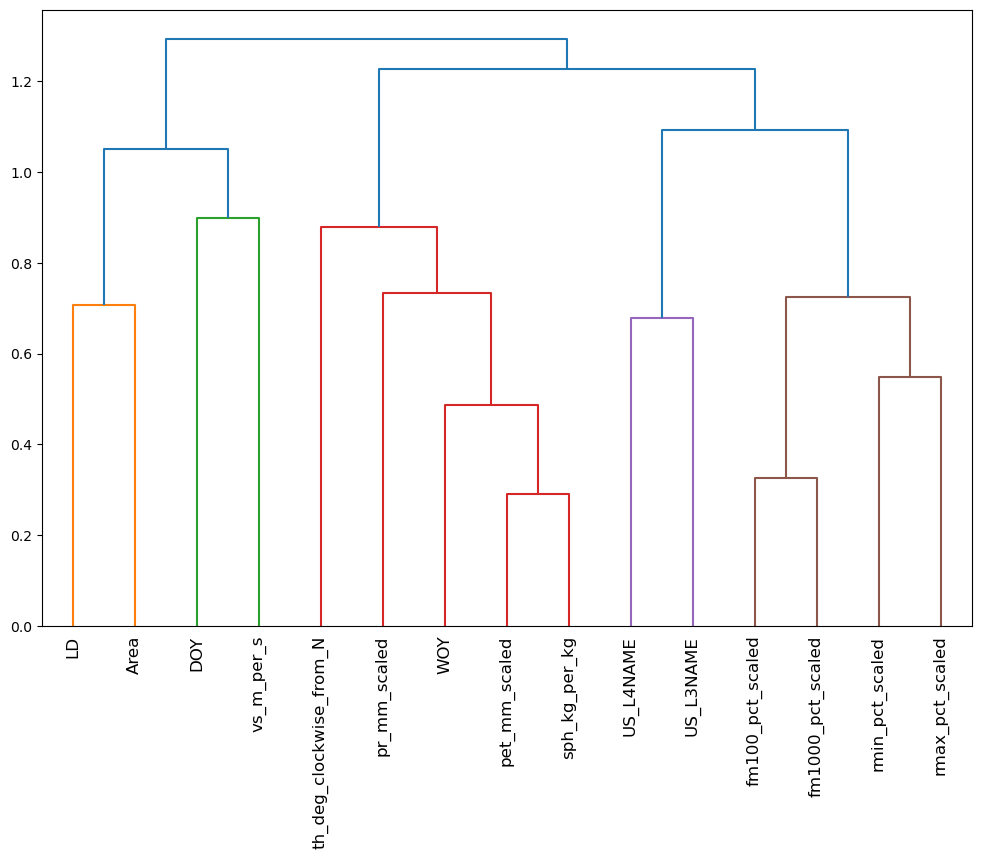

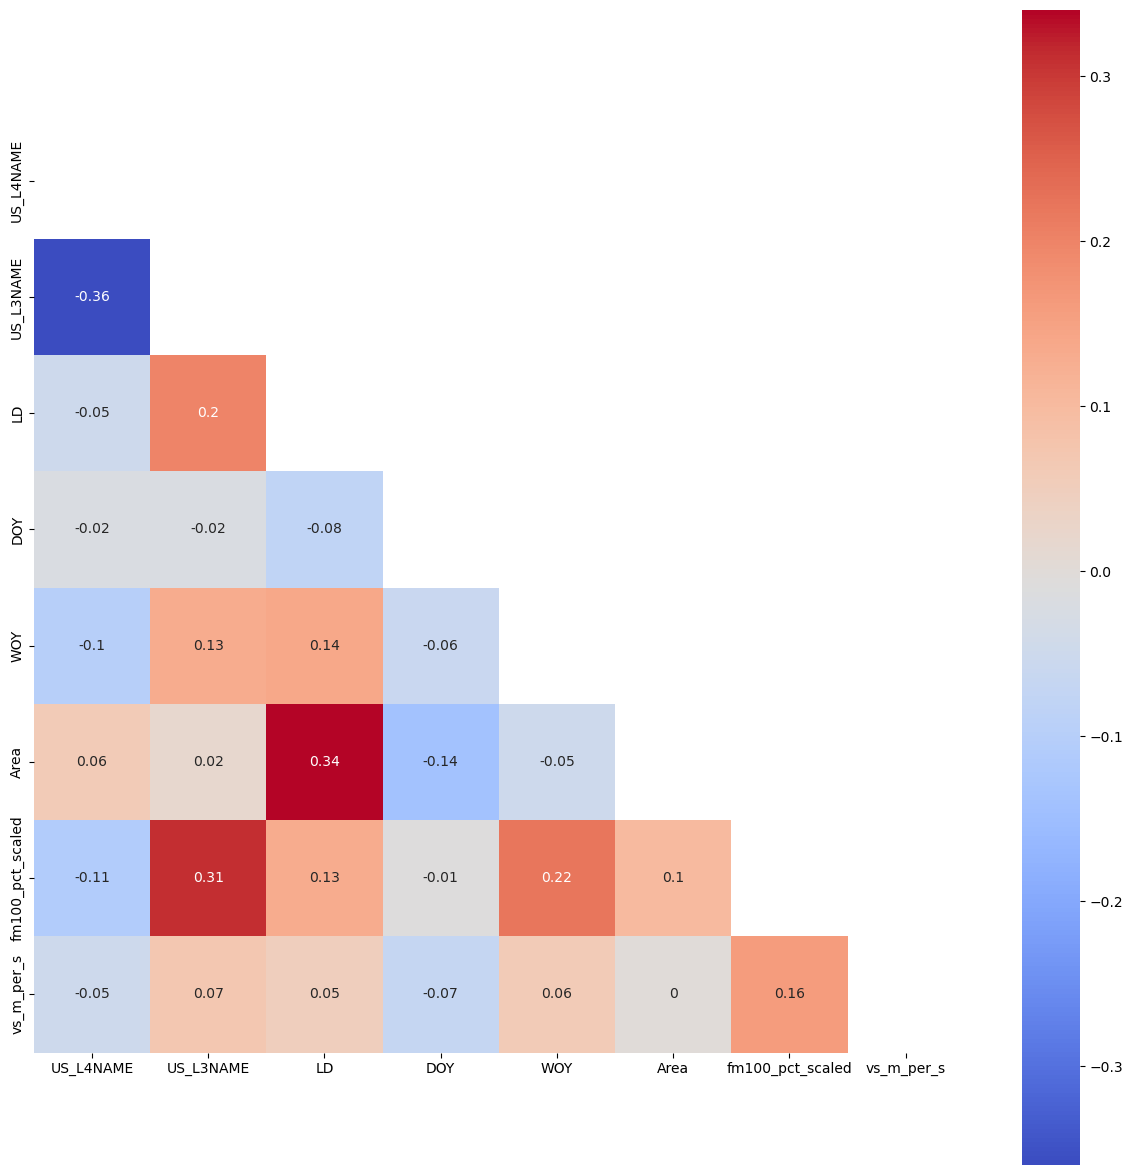

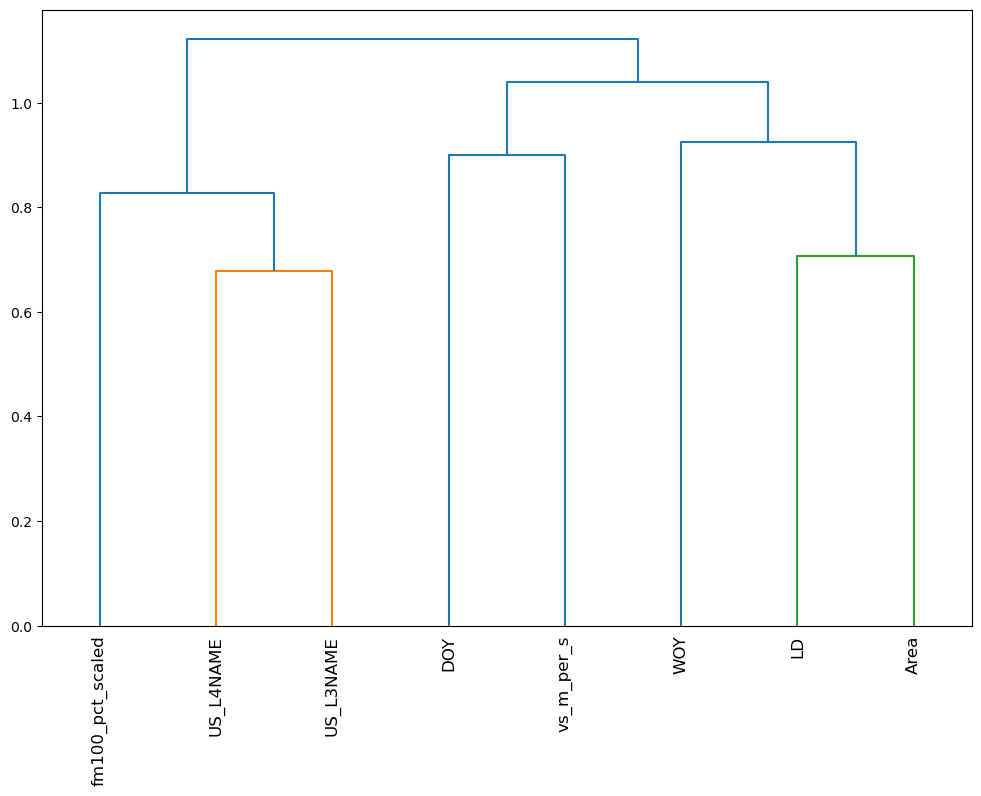

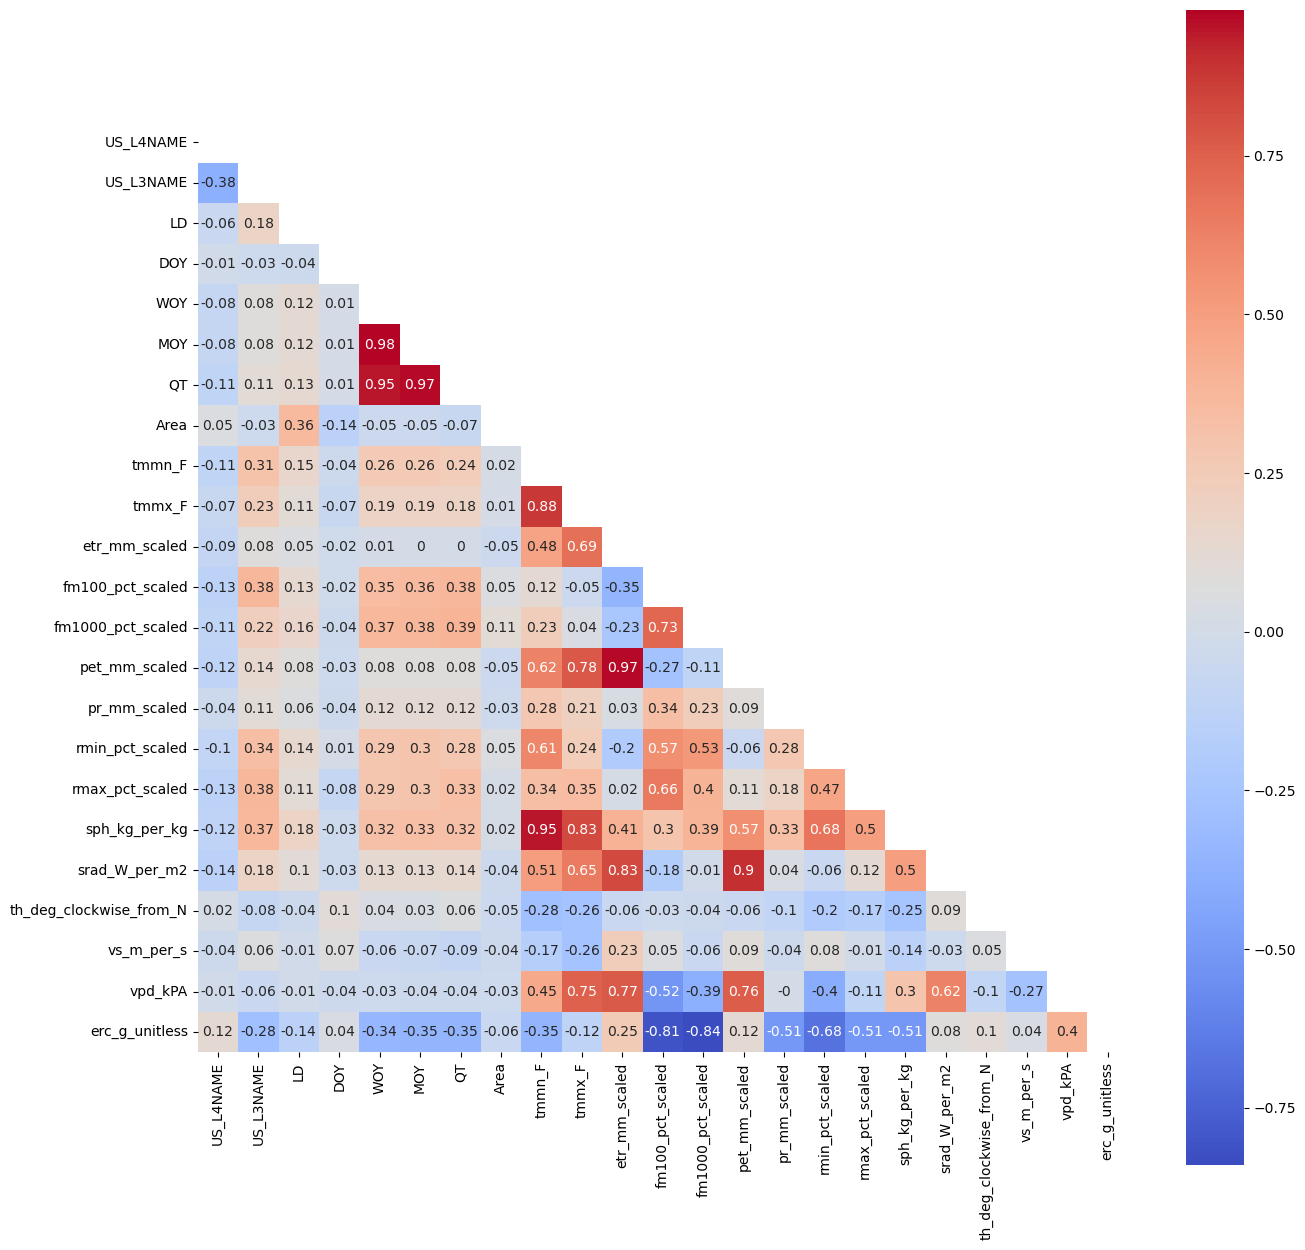

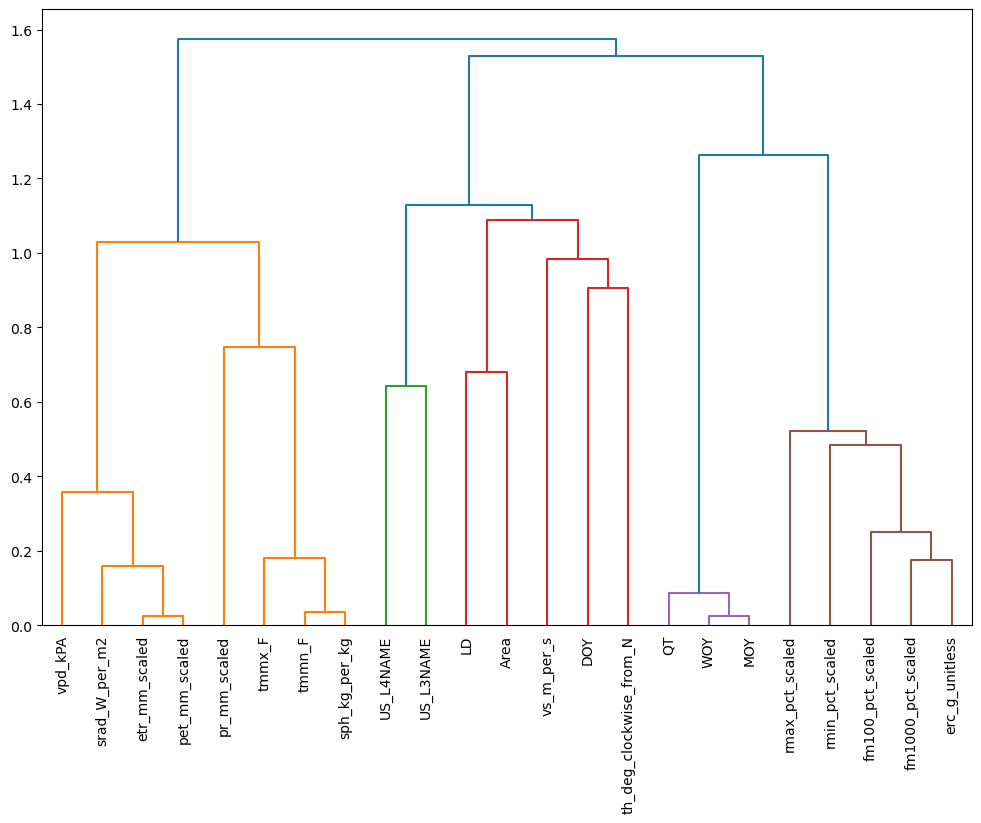

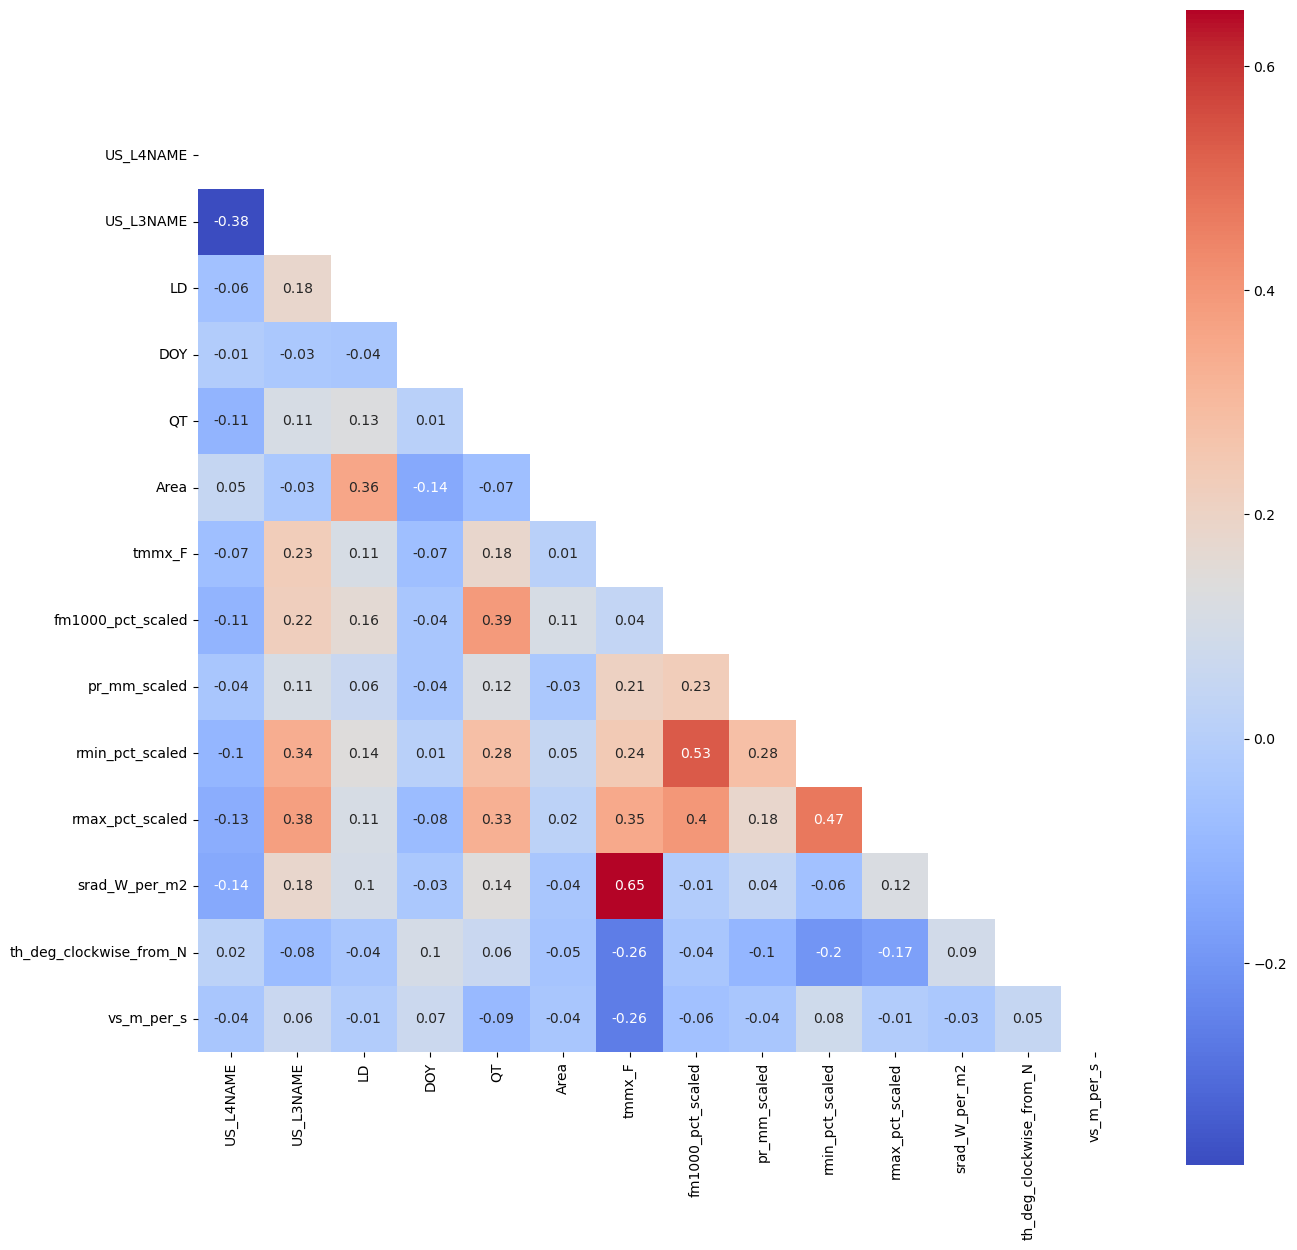

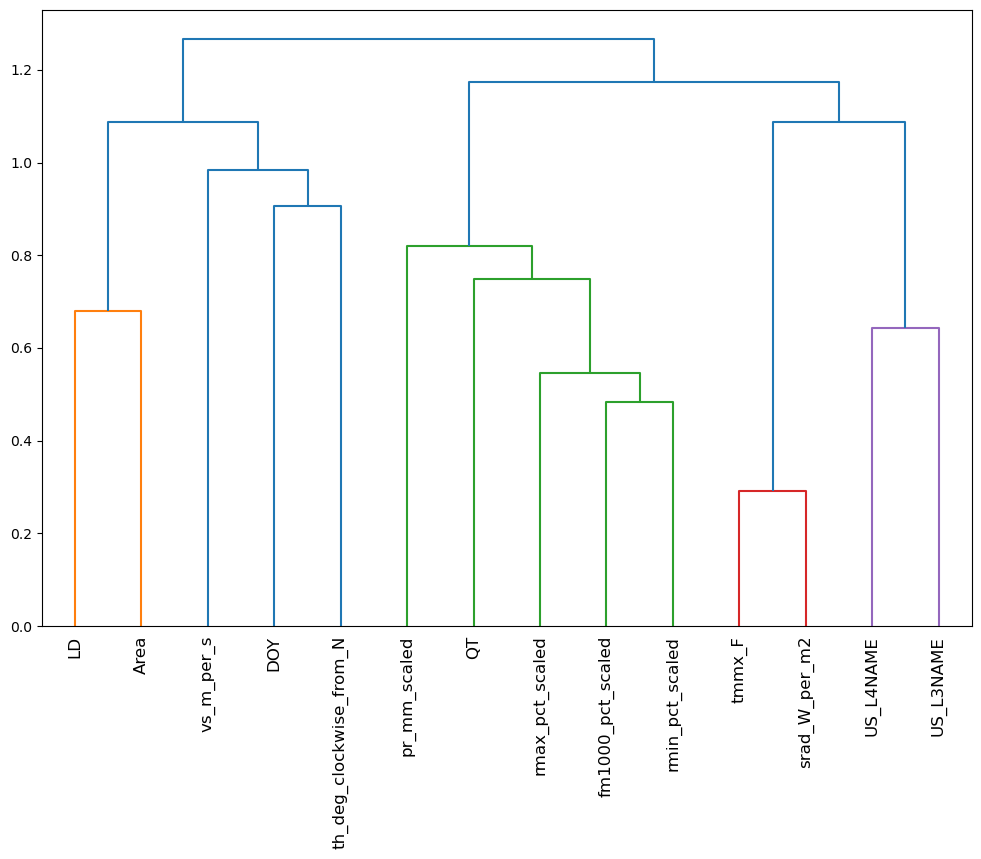

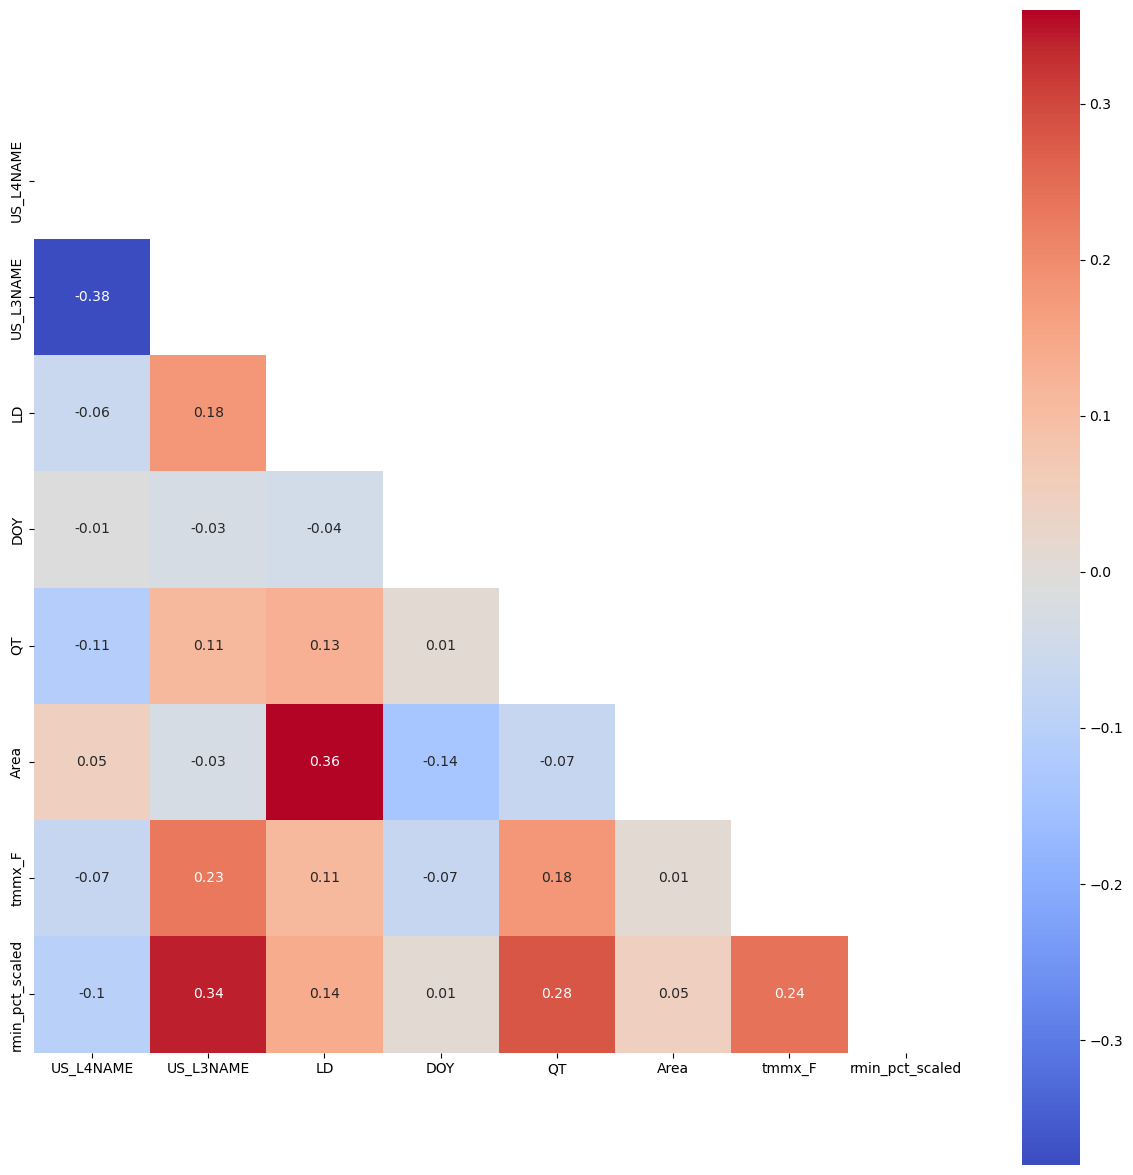

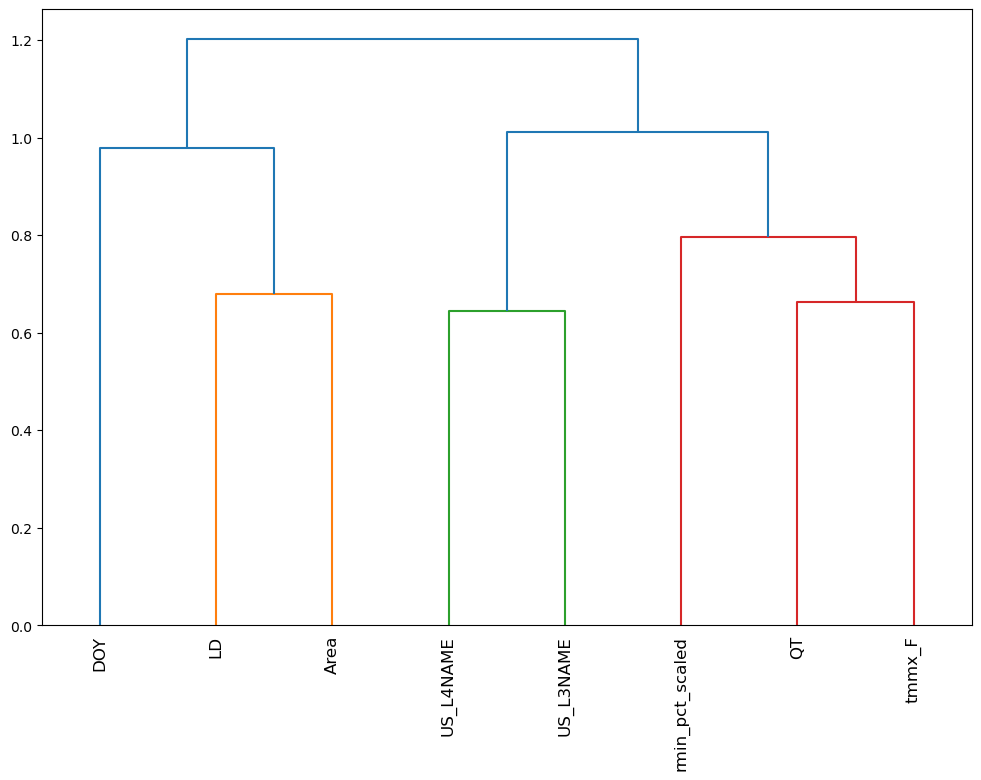

In [28]:
res = call_funcs(2010, 2012, original_data)

In [44]:
# RF for all years - manual

d = defaultdict(preprocessing.LabelEncoder)
data = original_data.drop('geometry', axis=1).apply(lambda x: d[x.name].fit_transform(x))
X, y = np.array(data.drop('Fire_Type', axis=1)), np.array(data['Fire_Type'])

RFC = RandomForestClassifier(n_estimators=100)

SNC = SelectNonCollinear(correlation_threshold=0.5, scoring=f_classif)

SFS = SequentialFeatureSelector(
    estimator=RFC,
    n_features_to_select=8,
    direction="forward",
    scoring="accuracy",
    cv=10,
    n_jobs=-1)

pipeline = make_pipeline(SNC, SFS, RFC)
pipeline.fit(X, y)


Pipeline(steps=[('selectnoncollinear',
                 <collinearity.SelectNonCollinear.SelectNonCollinear object at 0x0000018904F51490>),
                ('sequentialfeatureselector',
                 SequentialFeatureSelector(cv=10,
                                           estimator=RandomForestClassifier(),
                                           n_features_to_select=8, n_jobs=-1,
                                           scoring='accuracy')),
                ('randomforestclassifier', RandomForestClassifier())])

In [51]:
snc_mask = pipeline[0].get_support()
X_snc = data.drop('Fire_Type', axis=1).iloc[:, snc_mask]

sfs_mask = pipeline[1].get_support()
X_sfs = X_snc.iloc[:, sfs_mask]

X_train, X_test, y_train, y_test = train_test_split(X_sfs, y, test_size=0.3)
pipeline[2].fit(X_train, y_train)
y_pred = pipeline[2].predict(X_test)

In [52]:
acc_score = metrics.accuracy_score(y_test, y_pred)
avg_prec_score = metrics.average_precision_score(y_test, y_pred)
recall_score = metrics.recall_score(y_test, y_pred)
bal_acc_score = metrics.balanced_accuracy_score(y_test, y_pred)
f1_score = metrics.f1_score(y_test, y_pred)
roc_auc_score = metrics.roc_auc_score(y_test, y_pred)

print(acc_score, avg_prec_score, recall_score, bal_acc_score, f1_score, roc_auc_score)

0.9013351749539595 0.4241065015288694 0.509862423338306 0.73716715681311 0.5893849396436098 0.73716715681311


(array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35]),
 [Text(0.0, 0, '0.00'),
  Text(0.05, 0, '0.05'),
  Text(0.1, 0, '0.10'),
  Text(0.15000000000000002, 0, '0.15'),
  Text(0.2, 0, '0.20'),
  Text(0.25, 0, '0.25'),
  Text(0.30000000000000004, 0, '0.30'),
  Text(0.35000000000000003, 0, '0.35')])

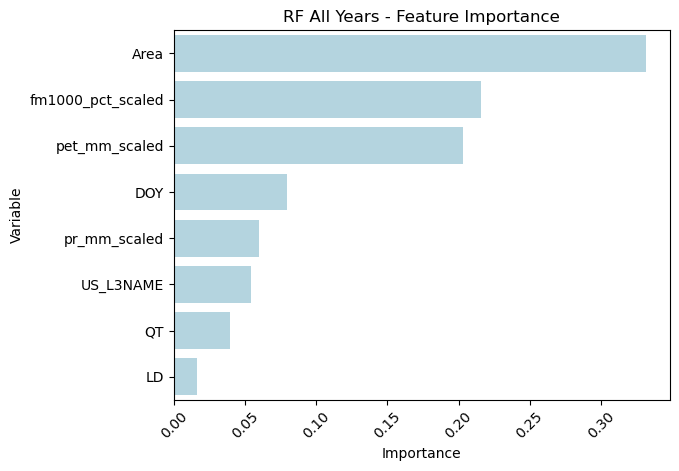

In [55]:
feature_imp = pd.DataFrame({"Variable": X_sfs.columns, "Importance": pipeline[2].feature_importances_}).sort_values("Importance", ascending=False)
sns.barplot(feature_imp, y="Variable", x="Importance", orient="h", color="lightblue")
plt.title('RF All Years - Feature Importance')
plt.xticks(rotation=45)

In [58]:
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
n_scores = cross_val_score(pipeline[2], X_sfs, y, scoring="accuracy", cv=cv, n_jobs=-1, error_score="raise")
n_scores.mean()

0.9013183806114323

Text(0.5, 1.0, 'Stratified K-Fold (n_folds=10)')

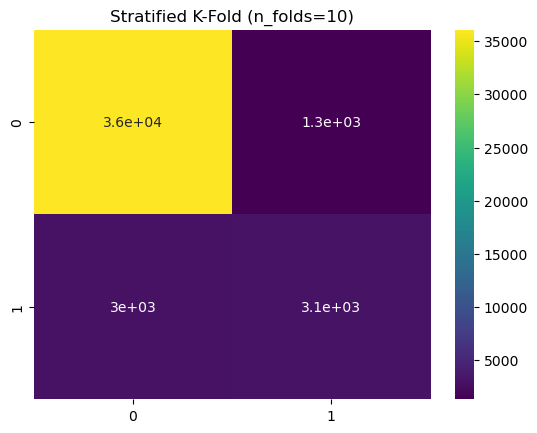

In [59]:
CM = confusion_matrix(y_test, y_pred)
sns.heatmap(CM, annot=True, cmap="viridis").set_title("Stratified K-Fold (n_folds=10)")

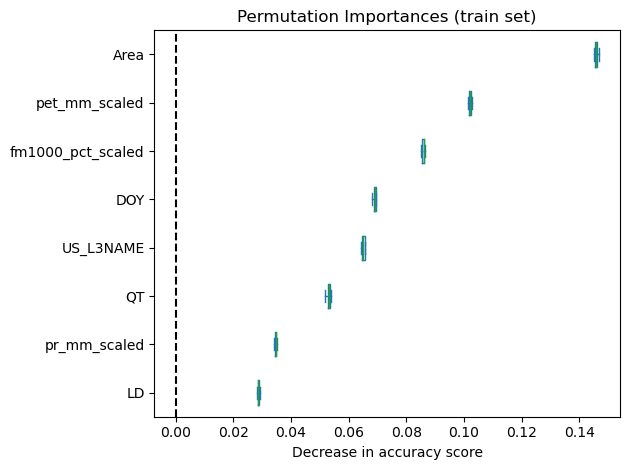

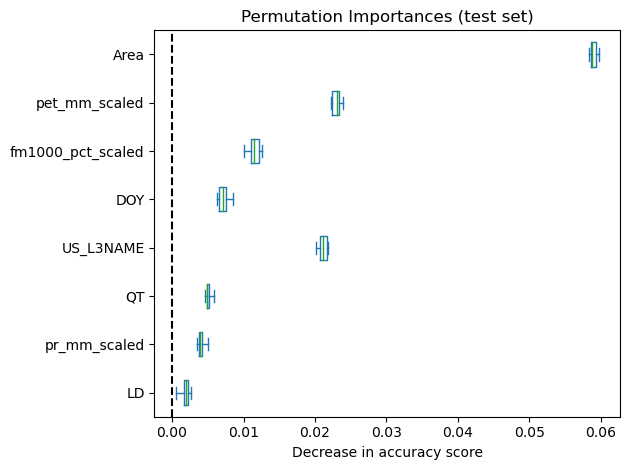

In [62]:
result = permutation_importance(pipeline[2], X_train, y_train, n_repeats=10, random_state=42, n_jobs=2)

sorted_importances_idx = result.importances_mean.argsort()

train_result = permutation_importance(pipeline[2], X_train, y_train, n_repeats=10, random_state=42, n_jobs=32)
test_results = permutation_importance(pipeline[2], X_test, y_test, n_repeats=10, random_state=42, n_jobs=32)
train_importances = pd.DataFrame(train_result.importances[sorted_importances_idx].T,columns=X_sfs.columns[sorted_importances_idx],)
test_importances = pd.DataFrame(test_results.importances[sorted_importances_idx].T,columns=X_sfs.columns[sorted_importances_idx],)

for name, importances in zip(["train", "test"], [train_importances, test_importances]):
    ax = importances.plot.box(vert=False, whis=10)
    ax.set_title(f"Permutation Importances ({name} set)")
    ax.set_xlabel("Decrease in accuracy score")
    ax.axvline(x=0, color="k", linestyle="--")
    ax.figure.tight_layout()